# FBProphet

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from fbprophet import Prophet
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Stores

In [2]:
def store_loc_search(store):
    location = {}
    
    stores_raw = pd.read_csv('input/stores.csv')
    location['city'] = stores_raw.loc[stores_raw['store_nbr']==store, 'city'].values[0]
    location['state'] = stores_raw.loc[stores_raw['store_nbr']==store, 'state'].values[0]
    return location

## Holidays

In [3]:
import calendar
def holidays(store):
    #holidays_events happens at the region of a store
    city,state = store_loc_search(store)
    holidays_events_raw = pd.read_csv('input/holidays_events.csv', parse_dates=['date'])
    mask = (holidays_events_raw['transferred'] == False)&(
        ((holidays_events_raw['locale']=='Local')&(holidays_events_raw['locale_name']==city))|
        ((holidays_events_raw['locale']=='Reginal')&(holidays_events_raw['locale_name']==state))|
        (holidays_events_raw['locale']=='National')
    )
    holidays_events = pd.DataFrame({
        'holiday':holidays_events_raw[mask]['type'],
        'ds':holidays_events_raw[mask]['date'],
        'lower_window':0,
        'upper_window':1,
    })
    
    
    #payoff days: Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month.
    payoff_dates = []
    for year in range(2013, 2018):
        for month in range(1,13):
            payoff_dates.append(str(year)+'-'+str(month)+'-15')
            payoff_dates.append(str(year)+'-'+str(month)+'-'+str(calendar.monthrange(year,month)[1]))
    payoffs = pd.DataFrame({
      'holiday': 'playoff',
      'ds': pd.to_datetime(payoff_dates),
      'lower_window': 0,
      'upper_window': 1,
    })
    
    #Put holiday_events and payoff_dates together
    holidays = pd.concat((holidays_events, payoffs)).fillna(0).sort_values(['ds'])
    return holidays

## Transactions

In [4]:
# transactions of a specific store
def transactions(store):
    transactions_raw = pd.read_csv('input/transactions.csv', parse_dates = ['date'])
    transactions = transactions_raw.loc[transactions_raw['store_nbr']==store].copy()
    transactions.drop(['store_nbr'], axis=1, inplace=True)
    transactions = transactions.rename(columns={'date': 'ds','transactions': 'y'})
    return transactions

## Main

In [5]:
store = 40
# set the uncertainty interval to 95% (the Prophet default is 80%)
phophet_model = Prophet(holidays=holidays(store), interval_width=0.95)
phophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
phophet_model.fit(transactions(store))
future = phophet_model.make_future_dataframe(periods=30, freq='d')
forecast = phophet_model.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


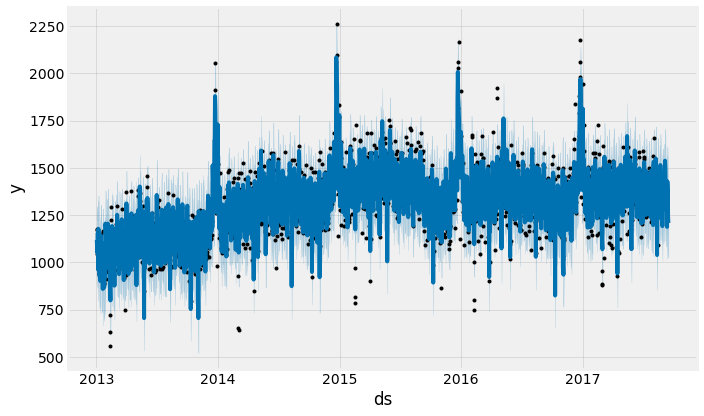

In [6]:
forecost_plot = phophet_model.plot(forecast, uncertainty=True)

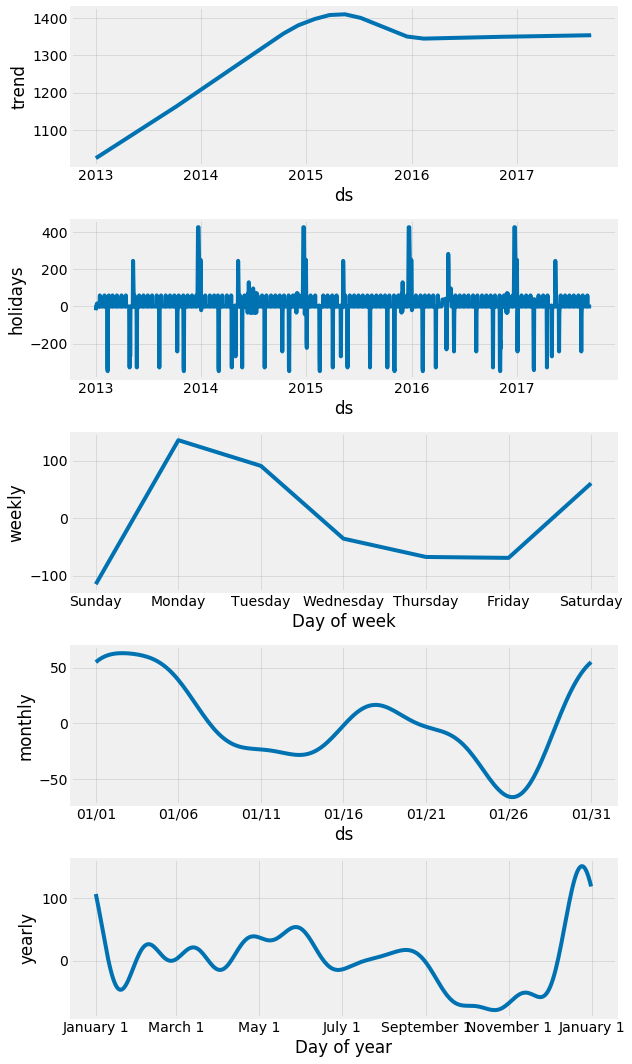

In [7]:
component_plot = phophet_model.plot_components(forecast)